# Preliminaries

In [55]:
# Import libraries
import networkx as nx
import os

# Define filepath
filepath = 'Instance Files/Delorme_200_NDD_Weight_0.txt'

# Strip filename from filepath
filename = os.path.basename(filepath)


TO Do:    Add weight calculations to the 3 cycle to 2 2 cycle section of the lns heuristic.

Configure in such a way that we run all 12 data, Saidman_50, delorme_200, as well as k = 3 and k=4 etc with one click and records heuristic calc times for eachof the 24 runs. Output to txt file would be chill

# Read in data

In [56]:
def import_kidney_data(filepath):
    """
    Imports kidney exchange data from a text file and structures it into a dictionary.

    Args:
        filepath (str): The path to the text file containing the kidney exchange data.

    Returns:
        dict: A dictionary containing the following keys:
            - num_pairs (int): The number of pairs (donor-patient pairs) in the instance.
            - num_ndd (int): The number of non-directed donors (NDDs) in the instance.
            - num_arcs (int): The total number of arcs in the instance.
            - pairs (list): A list of dictionaries, each representing a pair or NDD with the following keys:
                - id (int): The unique ID of the pair.
                - is_ndd (bool): True if the pair is an NDD, False otherwise.
                - donor_blood_type (int): Donor's blood type (0 = A, 1 = B, 2 = AB, 3 = O).
                - patient_blood_type (int): Patient's blood type (0 = A, 1 = B, 2 = AB, 3 = O).
                - patient_vpra (int): Patient's vPRA score (0 = below 0.5, 1 = between 0.5 and 0.85, 2 = above 0.85).
            - arcs (list): A list of dictionaries representing the arcs between pairs with the following keys:
                - donor_id (int): ID of the donor pair.
                - patient_id (int): ID of the patient pair.
                - weight (int): The weight of the arc (always 1 in this case).

    Example:
        data = import_kidney_data('path/to/data.txt')
        print(data['num_pairs'])  # Output: Number of pairs in the instance
    """

    data = {}
    
    # Open the file and read all lines into memory
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
        # Parse metadata: number of pairs, NDDs, and arcs
        num_pairs = int(lines[0].split(' ')[2])
        num_ndd = int(lines[1].split(' ')[2])
        num_arcs = int(lines[2].split(' ')[2])
        
        # Store the parsed values in the data dictionary
        data['num_pairs'] = num_pairs
        data['num_ndd'] = num_ndd
        data['num_arcs'] = num_arcs
        
        # Total number of entities (pairs + NDDs)
        num_things = num_pairs + num_ndd
        
        # List to store information about pairs and NDDs
        pairs = []
        
        # Parse each line corresponding to pairs and NDDs
        for line in lines[3:num_things + 3]:
            id, is_ndd, donor_blood_type, patient_blood_type, patient_vpra = map(int, line.strip().split(','))
            
            # Add pair/NDD info to the list
            pairs.append({
                'id': id,
                'is_ndd': bool(is_ndd),
                'donor_blood_type': donor_blood_type,
                'patient_blood_type': patient_blood_type,
                'patient_vpra': patient_vpra,
            })
        
        # Store the pairs data in the dictionary
        data['pairs'] = pairs

        # List to store information about arcs
        arcs = []
        
        # Parse each line corresponding to arcs (donor-patient relationships)
        for line in lines[num_things + 3:]:
            arc, weight = line.strip().split(',1,')
            
            # Extract donor and patient IDs from the arc
            donor_id, patient_id = arc.split(',')
            weight = int(weight.strip())  # Weight is always 1 in this context
            donor_id = int(donor_id[1:])  # Remove prefix and convert to int
            patient_id = int(patient_id[:-1])  # Remove suffix and convert to int
            
            # Add arc info to the list
            arcs.append({
                'donor_id': donor_id,
                'patient_id': patient_id,
                'weight': weight,
            })
        
        # Store the arcs data in the dictionary
        data['arcs'] = arcs

    # Return the final structured dictionary
    return data


# Example usage of the function
data = import_kidney_data(filepath)


In [57]:
# Display the number of pairs, NDDs, and arcs
print(f"Kidney exchange data from: {filename}")
print(f"Number of pairs: {data['num_pairs']}")
print(f"Number of NDDs: {data['num_ndd']}")
print(f"Number of arcs: {data['num_arcs']}")
print('')

# Access information about a specific arc
arc_id = 205
arc = data['arcs'][arc_id] 
print(f"Arc ID: {arc_id}")
print(f"Donor ID: {arc['donor_id']}")
print(f"Patient ID: {arc['patient_id']}")
print(f"Weight: {arc['weight']}")
print('')

# Access information about a specific pair (based on pair ID)
pair_id = 49
pair = data['pairs'][pair_id]
print(f"Pair ID: {pair_id}")
print(f"Is NDD: {pair['is_ndd']}")
print(f"Donor blood type: {pair['donor_blood_type']}")
print(f"Patient blood type: {pair['patient_blood_type']}")
print(f"Patient vPRA: {pair['patient_vpra']}")
print('')

# Print the complete data for debugging purposes (optional)
#print(data)


Kidney exchange data from: Delorme_200_NDD_Weight_0.txt
Number of pairs: 190
Number of NDDs: 10
Number of arcs: 4300

Arc ID: 205
Donor ID: 16
Patient ID: 112
Weight: 5

Pair ID: 49
Is NDD: False
Donor blood type: 1
Patient blood type: 1
Patient vPRA: 2



# Define graph functions

In [58]:
import numpy as np

def create_graph(data):
    """
    Creates a directed graph from the input data.

    Parameters:
    data (dict): A dictionary with two keys:
        - 'pairs': A list of dictionaries, each containing an 'id' for a node.
        - 'arcs': A list of dictionaries, each containing 'donor_id' (start node), 
                  'patient_id' (end node), and 'weight' (weight of the edge).

    Returns:
    G (nx.DiGraph): A directed graph created from the input data.
    """
    G = nx.DiGraph()
    
    # Add nodes to the graph from 'pairs' in data
    for pair in data['pairs']:
        G.add_node(pair['id'])
    
    # Add edges (directed) with weights from 'arcs' in data
    for arc in data['arcs']:
        G.add_edge(arc['donor_id'], arc['patient_id'], weight=arc['weight'])
    
    return G

In [59]:
def findPath(G, u, n):
    """
    Recursively finds all paths of length n starting from node u.

    Parameters:
    G (nx.DiGraph): A directed graph.
    u (hashable): The starting node of the path.
    n (int): The length of the paths to find.

    Returns:
    paths (list): A list of all possible paths of length n starting from node u. 
                  Each path is represented as a list of nodes.
    """
    if n == 0:
        # Base case: if the path length is 0, return the starting node as the path
        return [[u]]
    
    # Recursive case: explore neighbors of the current node and find paths of length n-1
    paths = [[u] + path for neighbor in G.successors(u) for path in findPath(G, neighbor, n-1)]
    
    return paths



def find_cycle(G, u, n):
    """
    Finds all cycles of length n starting and ending at node u.

    Parameters:
    G (nx.DiGraph): A directed graph.
    u (hashable): The node where the cycle starts and ends.
    n (int): The length of the cycle (number of edges in the cycle).

    Returns:
    cycles (list): A list of all cycles of length n starting and ending at node u.
                   Each cycle is represented as a tuple of nodes.
    """
    # Find all paths of length n starting from node u
    paths = findPath(G, u, n)
    
    # Filter paths that form a cycle, meaning they end at u and visit u exactly twice
    return [tuple(path) for path in paths if (path[-1] == u) and sum(x == u for x in path) == 2]

In [60]:
def set_weight(dict_list, donor_id, patient_id, weight_key="weight"):
    """
    Retrieve the weight of an arc between a donor and a patient.

    Args:
        dict_list (list): List of dictionaries representing arcs.
        donor_id (int): The ID of the donor.
        patient_id (int): The ID of the patient.
        weight_key (str): The key to access the weight in the dictionary (default is "weight").

    Returns:
        int: The weight of the arc if found, otherwise None.
    """
    for dct in dict_list:
        if dct.get("donor_id") == donor_id and dct.get("patient_id") == patient_id:
            return dct.get(weight_key)
    return None  # Return None if no matching arc is found


#Faster way to find weight of an arc using adjacency matrix
def get_weight(mat, donor_id, patient_id):
    return int(mat[donor_id][patient_id])

In [61]:
cycle_times = []

In [20]:
import time
'''
start_graph = time.time()

G = create_graph(data) # Create a directed graph from the data

end_graph = time.time()

#create weight matrix for faster lookup
num_things = len(G.nodes)
weight_matrix = np.zeros((num_things, num_things))
print('Graph time: {}'.format(end_graph-start_graph))


for arc in data['arcs']:
    weight_matrix[arc['donor_id']][arc['patient_id']] = arc['weight']

k = 3  # Maximum length for cycles and paths
 # List to store information about cycles
p = []  # List to store information about paths
for i in range(1):
    c = [] 
    startc = time.time()
    id_count = 0
    # Loop through possible cycle lengths from 1 to k
    for l in range(2, k+1):
        for node in G.nodes:  # Iterate over all nodes in the graph
            for cyc in list(find_cycle(G, node, l)):
                # Find all cycles starting at this node of length 'l'
                cyc_success = 0
                cyc_weight = 0
                
                # Calculate the success and weight for the cycle
                for n in range(1, len(cyc)):
                    cyc_success += data['pairs'][cyc[n]]['patient_vpra']  # Sum up the vPRA values of patients in the cycle
                    cyc_weight += set_weight(data['arcs'], cyc[n-1], cyc[n])  # Add the weight of the arc between consecutive pairs in the cycle
                    #cyc_weight += get_weight(weight_matrix, cyc[n-1], cyc[n])  # Add the weight of the arc using adjacency matrix
                
                # Append the cycle info to the list 'c'
                c.append({'id': id_count,'cycle': cyc, 'vpra_sum': cyc_success, 'weight_sum': cyc_weight})  
                id_count += 1
    
    endc = time.time()
    
    print('cycle time: {}'.format(endc-startc))
    cycle_times.append(endc-startc)
    startp = time.time()
    # Loop through possible path lengths from 1 to k-2 (since paths are from NDDs)
    for l in range(1, k):
        for node in G.nodes:  # Iterate over all nodes in the graph
            if data['pairs'][node]['is_ndd']:  # Only consider nodes that are NDDs
                for path in list(findPath(G, node, l)):  # Find all paths starting at this NDD node of length 'l'
                    path_success = 0
                    path_weight = 0
                    
                    # Calculate the success and weight for the path
                    for n in range(1, len(path)):
                        path_success += data['pairs'][path[n]]['patient_vpra']  # Sum up the vPRA values of patients in the path
                        path_weight += set_weight(data['arcs'], cyc[n-1], cyc[n])  # Add the weight of the arc between consecutive pairs in the path
                    # Append the path info to the list 'p'
                    
                    c.append({'id':id_count,'cycle': path, 'vpra_sum': path_success, 'weight_sum': path_weight}) 
                    id_count += 1
    endp = time.time()
    
    print('path time: {}'.format(endp-startp))
# Print the results
print("Cycles/paths:", id_count) 
#print("Paths:", p)
'''

'\nstart_graph = time.time()\n\nG = create_graph(data) # Create a directed graph from the data\n\nend_graph = time.time()\n\n#create weight matrix for faster lookup\nnum_things = len(G.nodes)\nweight_matrix = np.zeros((num_things, num_things))\nprint(\'Graph time: {}\'.format(end_graph-start_graph))\n\n\nfor arc in data[\'arcs\']:\n    weight_matrix[arc[\'donor_id\']][arc[\'patient_id\']] = arc[\'weight\']\n\nk = 3  # Maximum length for cycles and paths\n # List to store information about cycles\np = []  # List to store information about paths\nfor i in range(1):\n    c = [] \n    startc = time.time()\n    id_count = 0\n    # Loop through possible cycle lengths from 1 to k\n    for l in range(2, k+1):\n        for node in G.nodes:  # Iterate over all nodes in the graph\n            for cyc in list(find_cycle(G, node, l)):\n                # Find all cycles starting at this node of length \'l\'\n                cyc_success = 0\n                cyc_weight = 0\n                \n         

## NEW VERSION of cycle generatio below

### old one is kept above for testing. Adjust for loop if you only want to run once

In [62]:
import networkx as nx

def canonical_form(cycle):
    """
    Returns the canonical form of a cycle by rotating it to start with the smallest node.
    """
    min_index = cycle.index(min(cycle))
    return tuple(cycle[min_index:] + cycle[:min_index])

def findPaths(G, u, n, memo):
    """
    Recursively finds all paths of length n starting from node u, using memoization.
    
    Parameters:
    G (nx.DiGraph): A directed graph.
    u (hashable): The starting node of the path.
    n (int): The length of the paths to find.
    memo (dict): A memoization dictionary for storing already computed paths.

    Returns:
    paths (list): A list of all possible paths of length n starting from node u.
    """
    if (u, n) in memo:
        return memo[(u, n)]

    if n == 0:
        return [[u]]

    paths = [[u] + path for neighbor in G.successors(u) for path in findPaths(G, neighbor, n-1, memo)]
    
    memo[(u, n)] = paths
    return paths

def is_valid_cycle_build(path):
    """
    Checks if a path forms a valid cycle.
    
    A valid cycle must start and end at the same node, and no internal node should repeat.
    """
    return path[-1] == path[0] and len(set(path[:-1])) == len(path) - 1

def find_cycles(G, u, n, memo):
    """
    Finds all cycles of length n starting and ending at node u, and ensures no duplicates using canonical form.

    Parameters:
    G (nx.DiGraph): A directed graph.
    u (hashable): The node where the cycle starts and ends.
    n (int): The length of the cycle (number of edges in the cycle).
    memo (dict): A memoization dictionary for storing already computed paths.

    Returns:
    cycles (list): A list of all cycles of length n starting and ending at node u.
    """
    # Find all paths of length n starting from node u
    paths = findPaths(G, u, n, memo)

    # Filter paths that form a valid cycle and return in canonical form
    cycles = [canonical_form(path) for path in paths if is_valid_cycle_build(path)]

    return list(set(cycles))

def find_all_cycles_in_sccs(G, k):
    """
    Finds all unique cycles of length up to k in the strongly connected components of the graph.
    
    Parameters:
    G (nx.DiGraph): A directed graph.
    k (int): The maximum length of the cycles.

    Returns:
    cycles (list): A list of all unique cycles in the graph, up to length k.
    """
    c = set()  # Use a set to store unique cycles

    # Get all strongly connected components
    sccs = nx.strongly_connected_components(G)

    for scc in sccs:
        subgraph = G.subgraph(scc)  # Only search within the SCC
          # Memoization dictionary for storing already computed paths
        for l in range(2, k + 1):
            memo = {}
            for node in subgraph.nodes:
                for cyc in find_cycles(subgraph, node, l, memo):
                    if is_valid_cycle_build(cyc):
                        c.add(cyc)  # Store the canonical form

    return list(c)

# Test usage:
test = nx.DiGraph()
test.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4), (4, 2), (2, 5)])

# Find all unique cycles of length up to 3
k = 3
cycles = find_all_cycles_in_sccs(test, k)
print(cycles)


[(2, 3, 4, 2), (1, 2, 3, 1)]


In [63]:
cycle_time_new = []

In [64]:

import time

start_graph = time.time()

G = create_graph(data) # Create a directed graph from the data

end_graph = time.time()

#create weight matrix for faster lookup
num_things = len(G.nodes)
weight_matrix = np.zeros((num_things, num_things))
print('Graph time: {}'.format(end_graph-start_graph))


for arc in data['arcs']:
    weight_matrix[arc['donor_id']][arc['patient_id']] = arc['weight']

k = 3  # Maximum length for cycles and paths
 # List to store information about cycles
p = []  # List to store information about paths

#### How many times to run (to test runtime)  Make 1 to generate cycles once
for i in range(1):
    c = [] 
    startc = time.time()
    id_count = 0
    for cyc in list(find_all_cycles_in_sccs(G, k)):
        # Find all cycles starting at this node of length 'l'
        #cyc_success = 0
        cyc_weight = 0
                
        # Calculate the success and weight for the cycle
        for n in range(1, len(cyc)):
            #cyc_success += data['pairs'][cyc[n]]['patient_vpra']  # Sum up the vPRA values of patients in the cycle
            #cyc_weight += set_weight(data['arcs'], cyc[n-1], cyc[n])  # Add the weight of the arc between consecutive pairs in the cycle
            cyc_weight += get_weight(weight_matrix, cyc[n-1], cyc[n])  # Add the weight of the arc between consecutive pairs in the cycle
                
        # Append the cycle info to the list 'c'
        c.append({'id': id_count,'cycle': cyc, 'weight_sum': cyc_weight})  
        id_count += 1
    
    endc = time.time()
    
    print('cycle time: {}'.format(endc-startc))
    cycle_time_new.append(endc-startc)
    startp = time.time()
    # Loop through possible path lengths from 1 to k-2 (since paths are from NDDs)
    for l in range(1, k):
        for node in G.nodes:  # Iterate over all nodes in the graph
            if data['pairs'][node]['is_ndd']:  # Only consider nodes that are NDDs
                for path in list(findPath(G, node, l)):  # Find all paths starting at this NDD node of length 'l'
                    path_success = 0
                    path_weight = 0
                
                    # Calculate the success and weight for the path
                    for n in range(1, len(path)):
                        #path_success += data['pairs'][path[n]]['patient_vpra']  # Sum up the vPRA values of patients in the path
                        path_weight += get_weight(weight_matrix, path[n-1], path[n])  # Add the weight of the arc between consecutive pairs in the path
                    # Append the path info to the list 'p'
                    
                    c.append({'id':id_count,'cycle': path, 'weight_sum': path_weight}) 
                    id_count += 1
    endp = time.time()
    
    print('path time: {}'.format(endp-startp))
# Print the results
print("Cycles/paths:", id_count) 
#print("Paths:", p)

Graph time: 0.05226016044616699
cycle time: 0.543370246887207
path time: 0.01359248161315918
Cycles/paths: 3233


In [24]:
import statistics


#print('old method avg time', statistics.mean(cycle_times))
print('new method avg time:', statistics.mean(cycle_time_new))

new method avg time: 0.47765064239501953


In [69]:
def get_stats(cycles, mat):
    transplants_made = 0 
    total_weight = 0
    for c1 in cycles:
        transplants_made += len(c1['cycle'])-1
        for i in range(0, len(c1['cycle'])-1):
            total_weight += get_weight(mat, c1['cycle'][i], c1['cycle'][i+1])
    return transplants_made, total_weight

## Heuristics

#### Largest Weight Heuristic (Constructive)

In [70]:
def largest_weight_heuristic(cycles):
    """
    Implements the largest weight heuristic for selecting cycles in the kidney exchange problem.

    Args:
        cycles: A list of cycles, where each cycle is represented as a dictionary with keys 'id', 'cyc', and 'weight'.

    Returns:
        A list of selected cycles.
    """

    selected_cycles = []
    while cycles:
        # Find the cycle with the largest weight
        max_weight_cycle = max(cycles, key=lambda c3: c3['weight_sum'])

        # Remove cycles that are not disjoint from the selected cycles
        disjoint_cycles = [c2 for c2 in cycles if not set(max_weight_cycle['cycle']).intersection(set(c2['cycle']))]

        # Add the selected cycle to the list of selected cycles
        selected_cycles.append(max_weight_cycle)
        cycles = disjoint_cycles   
    return selected_cycles, cycles

In [72]:
selected_cycles, remaining = largest_weight_heuristic(c)
print(selected_cycles)
transplants_made, total_weight = get_stats(selected_cycles, weight_matrix)
print('total transplants: {}, {}'.format(transplants_made, total_weight))

[{'id': 157, 'cycle': (51, 85, 187, 51), 'weight_sum': 234}, {'id': 236, 'cycle': (54, 79, 149, 54), 'weight_sum': 211}, {'id': 193, 'cycle': (20, 139, 142, 20), 'weight_sum': 183}, {'id': 133, 'cycle': (52, 93, 154, 52), 'weight_sum': 174}, {'id': 1750, 'cycle': [193, 6, 50], 'weight_sum': 174}, {'id': 2895, 'cycle': [196, 105, 171], 'weight_sum': 173}, {'id': 235, 'cycle': (24, 182, 72, 24), 'weight_sum': 172}, {'id': 2277, 'cycle': [195, 57, 76], 'weight_sum': 171}, {'id': 1032, 'cycle': [190, 167, 70], 'weight_sum': 170}, {'id': 1401, 'cycle': [192, 74, 35], 'weight_sum': 169}, {'id': 97, 'cycle': (73, 141, 189, 73), 'weight_sum': 155}, {'id': 3201, 'cycle': [198, 159, 152], 'weight_sum': 146}, {'id': 3228, 'cycle': [199, 90, 123], 'weight_sum': 74}, {'id': 134, 'cycle': (140, 145, 140), 'weight_sum': 60}]
total transplants: 34, 2266


#### Neigborhood Search Heuristic

Makes 3 cycles from 2 cycles, splits 3 cycles into 2 2 cycles

In [52]:
def is_valid_cycle(cycle, mat):
    """
    Checks if a given cycle is valid in a kidney exchange problem.

    Args:
        cycle: A list of pairs (donor_id, recipient_id) representing the cycle.
        compatibility_graph: A graph representing compatibility between donors and recipients.
        used_donors: A set of used donors.
        used_recipients: A set of used recipients.

    Returns:
        True if the cycle is valid, False otherwise.
    """
    arcs = data['arcs']
    for i in range(len(cycle)-1):
        #print(type(cycle[i]))
        if get_weight(mat, cycle[i], cycle[i+1]) > 0:
            continue
        else:
            return False

    return True




def heuristic_with_lns(selected_cycles, cycles, unassigned_vertecies, mat):
    """
    Implements the largest weight heuristic for selecting cycles in the kidney exchange problem.

    Args:
        cycles: A list of cycles, where each cycle is represented as a dictionary with keys 'id', 'cyc', and 'weight'.

    Returns:
        A list of selected cycles.
    """

    
    while cycles:
        # Find the cycle with the largest weight
        max_weight_cycle = max(cycles, key=lambda c: c['weight_sum'])

        # Remove cycles that are not disjoint from the selected cycles
        disjoint_cycles = [c for c in cycles if not set(max_weight_cycle['cycle']).intersection(set(c['cycle']))]

        # Add the selected cycle to the list of selected cycles
        selected_cycles.append(max_weight_cycle)
        cycles = disjoint_cycles
    print('Step 2')
    # Remove used vertices from unassigned_vertices
    for cycle in selected_cycles:
        for vertex in cycle['cycle']:
            if vertex in unassigned_vertecies:
                unassigned_vertecies.remove(vertex)
    print('step3 done')
    # Step 4: Try to convert 2-way cycles to 3-way cycles
    cnt = 0
    for cycle in selected_cycles:
        if cnt % 5 == 0:
            cnt += 1
            print(cnt)
        if len(cycle['cycle']) == 3:
            if cycle['cycle'][0] == cycle['cycle'][2]:
                for unassigned_vertex_d in unassigned_vertecies:
                    unassigned_vertex = unassigned_vertex_d
    
                    new_cyc1 = [cycle['cycle'][0], cycle['cycle'][1], unassigned_vertex, cycle['cycle'][2]]
                    new_cyc2 = [cycle['cycle'][1], unassigned_vertex, cycle['cycle'][1], cycle['cycle'][2]]
                    #print(new_cyc1)
                    if is_valid_cycle(new_cyc1, mat):
                        # Find the edge weights based on donor_id and patient_id
                        weight1 = mat[cycle['cycle'][0], cycle['cycle'][1]]
                        weight2 = mat[unassigned_vertex, cycle['cycle'][2]]
                        weight3 = mat[cycle['cycle'][1], unassigned_vertex]
                        new_cycle = {'id': cycle['id'], 'cycle': new_cyc1, 'weight_sum': cycle['weight_sum'] + weight1 + weight2}                    
                        selected_cycles.remove(cycle)
                        selected_cycles.append(new_cycle)
                        unassigned_vertecies.remove(unassigned_vertex_d)
                        print('cycle added1')
                        break
                    if is_valid_cycle(new_cyc2, mat):
                        # Find the edge weights based on donor_id and patient_id
                        weight1 = mat[cycle['cycle'][0], unassigned_vertex]
                        weight2 = mat[unassigned_vertex, cycle['cycle'][1]]
                        weight3 = mat[cycle['cycle'][1], cycle['cycle'][2]]
                        new_cycle = {'id': 222222, 'cycle': new_cyc1, 'weight_sum': cycle['weight_sum'] + weight1 + weight2}                    
                        selected_cycles.remove(cycle)
                        selected_cycles.append(new_cycle)
                        unassigned_vertecies.remove(unassigned_vertex_d)
                        print('cycle added 2')
                        break

    # Step 5: Try to convert 3-way cycles to two disjoint 2-way cycles
    for cycle in selected_cycles:
        if len(cycle['cycle']) == 4:
            if cycle['cycle'][0] == cycle['cycle'][3]:
                for unassigned_vertex_d in unassigned_vertecies:
                    unassigned_vertex = unassigned_vertex_d
                    # Find the edge weights based on donor_id and patient_id
                    #weight1 = next((edge['weight'] for edge in edge_weights if edge['donor_id'] == cycle['cycle'][0] and edge['patient_id'] == unassigned_vertex), 0)
                    #weight2 = next((edge['weight'] for edge in edge_weights if edge['donor_id'] == unassigned_vertex and edge['patient_id'] == cycle['cycle'][1]), 0)
                    #weight3 = next((edge['weight'] for edge in edge_weights if edge['donor_id'] == cycle['cycle'][1] and edge['patient_id'] == cycle['cycle'][2]), 0)
                    c_1 = [cycle['cycle'][0], unassigned_vertex, cycle['cycle'][0]]
                    c_2 = [cycle['cycle'][2], cycle['cycle'][1], cycle['cycle'][2]]
                    
                    if is_valid_cycle(c_1, mat) and is_valid_cycle(c_2, mat):
                        selected_cycles.remove(cycle)
                        w_1 = get_weight(mat, c_1[0], c_1[1]) + get_weight(mat, c_1[1], c_1[2])
                        w_2 = get_weight(mat, c_2[0], c_2[1]) + get_weight(mat, c_2[1], c_2[2])
                        cycle1 = {'id':  33331, 'cycle': c_1, 'weight_sum': w_1}
                        cycle2 = {'id': 33332, 'cycle': c_2, 'weight_sum': w_2}
                        selected_cycles.append(cycle1)
                        selected_cycles.append(cycle2)
                        unassigned_vertecies.remove(unassigned_vertex_d)
                        print(unassigned_vertex)
                        print('cycle added3')
                        break
                    c_1 = [cycle['cycle'][1], unassigned_vertex, cycle['cycle'][1]]
                    c_2 = [cycle['cycle'][2], cycle['cycle'][0], cycle['cycle'][2]]
                    if is_valid_cycle(c_1, mat) and is_valid_cycle(c_2, mat):
                        selected_cycles.remove(cycle)
                        w_1 = get_weight(mat, c_1[0], c_1[1]) + get_weight(mat, c_1[1], c_1[2])
                        w_2 = get_weight(mat, c_2[0], c_2[1]) + get_weight(mat, c_2[1], c_2[2])
                        cycle1 = {'id':  33331, 'cycle': c_1, 'weight_sum': w_1}
                        cycle2 = {'id': 33332, 'cycle': c_2, 'weight_sum': w_2}
                        selected_cycles.append(cycle1)
                        selected_cycles.append(cycle2)
                        unassigned_vertecies.remove(unassigned_vertex_d)
                        print(unassigned_vertex)
                        print('cycle added4')
                        break
                    c_1 = [cycle['cycle'][2], unassigned_vertex, cycle['cycle'][2]]
                    c_2 = [cycle['cycle'][1], cycle['cycle'][0], cycle['cycle'][1]]
                    if is_valid_cycle(c_1, mat) and is_valid_cycle(c_2, mat):
                        selected_cycles.remove(cycle)
                        w_1 = get_weight(mat, c_1[0], c_1[1]) + get_weight(mat, c_1[1], c_1[2])
                        w_2 = get_weight(mat, c_2[0], c_2[1]) + get_weight(mat, c_2[1], c_2[2])
                        cycle1 = {'id':  33331, 'cycle': c_1, 'weight_sum': w_1}
                        cycle2 = {'id': 33332, 'cycle': c_2, 'weight_sum': w_2}
                        selected_cycles.append(cycle1)
                        selected_cycles.append(cycle2)
                        unassigned_vertecies.remove(unassigned_vertex_d)
                        print(unassigned_vertex)
                        print('cycle added 5')
                        break

    return selected_cycles

In [53]:
weight_matrix = np.zeros((num_things, num_things))

for arc in data['arcs']:
    weight_matrix[arc['donor_id']][arc['patient_id']] = arc['weight']


In [73]:
uv = []
for item in data['pairs']:
    uv.append(item['id'])
selected, remaining = largest_weight_heuristic(c)
selected_cycles = heuristic_with_lns(selected, remaining, uv, weight_matrix)
print(selected_cycles)

transplants_made, total_weight = get_stats(selected_cycles, weight_matrix)

print(transplants_made, total_weight)

Step 2
step3 done
1
34
cycle added4
[{'id': 157, 'cycle': (51, 85, 187, 51), 'weight_sum': 234}, {'id': 193, 'cycle': (20, 139, 142, 20), 'weight_sum': 183}, {'id': 133, 'cycle': (52, 93, 154, 52), 'weight_sum': 174}, {'id': 1750, 'cycle': [193, 6, 50], 'weight_sum': 174}, {'id': 2895, 'cycle': [196, 105, 171], 'weight_sum': 173}, {'id': 235, 'cycle': (24, 182, 72, 24), 'weight_sum': 172}, {'id': 2277, 'cycle': [195, 57, 76], 'weight_sum': 171}, {'id': 1032, 'cycle': [190, 167, 70], 'weight_sum': 170}, {'id': 1401, 'cycle': [192, 74, 35], 'weight_sum': 169}, {'id': 97, 'cycle': (73, 141, 189, 73), 'weight_sum': 155}, {'id': 3201, 'cycle': [198, 159, 152], 'weight_sum': 146}, {'id': 3228, 'cycle': [199, 90, 123], 'weight_sum': 74}, {'id': 134, 'cycle': (140, 145, 140), 'weight_sum': 60}, {'id': 33331, 'cycle': [79, 34, 79], 'weight_sum': 51}, {'id': 33332, 'cycle': [149, 54, 149], 'weight_sum': 78}]
35 2184


0

Advanced Constructive heuristic

In [74]:
def add_info(data):
    p = []
    G = create_graph(data)
    for pair in G.nodes:
        info = {'patient_type':data['pairs'][pair]['patient_blood_type'], 'pot_donors' : len(list(G.predecessors(pair)))}
        data['pairs'][pair]['Av_donors'] = len(list(G.predecessors(pair)))
        p.append(info)
    p[0:3]
    
    d = []
    G = create_graph(data)
    for pair in G.nodes:
        info = {'donor_type':data['pairs'][pair]['donor_blood_type'], 'recipients' : len(list(G.successors(pair)))}
        data['pairs'][pair]['Av_recip'] = len(list(G.successors(pair)))
    
        d.append(info)
    d[0:3]
    return data

In [75]:
def sort_cycles(c):
    for cycle in c:
        cyc = cycle['cycle']
        tot = 0
        mini = []
        for rec in range(1,len(cyc)):
            curr = cyc[rec]
            curr_num = data['pairs'][curr]['Av_donors']
            tot += curr_num
            mini.append(curr_num)
        #cycle['total_Av_donors'] = tot
        cycle['min_donors'] = min(mini)
        cycle['max_donors'] = max(mini)
        for don in range(0,len(cyc)-1):
            curr = cyc[don]
            curr_num = data['pairs'][curr]['Av_recip']
            tot += curr_num
            mini.append(curr_num)
        #cycle['total_Av_recip'] = tot
        cycle['min_recip'] = min(mini)
        cycle['max_recip'] = max(mini)

    sorted_data = sorted(c, key=lambda x: x['min_donors']+x['max_recip'], reverse=False)
    return sorted_data




In [78]:
def dd_heuristic(cycles):
    selected_cycles = []
    while cycles:
        # Find the cycle where recipient with fewest option, plus donor with the most potential is minimized
        desperate_donor_cycle = min(cycles, key=lambda x: (5*x['min_donors']+x['max_recip'])/(len(x['cycle'])-1))

        # Remove cycles that are not disjoint from the selected cycles
        disjoint_cycles = [c for c in cycles if not set(desperate_donor_cycle['cycle']).intersection(set(c['cycle']))]

        # Add the selected cycle to the list of selected cycles
        selected_cycles.append(desperate_donor_cycle)
        cycles = disjoint_cycles
    return selected_cycles, cycles

In [82]:
data = add_info(data)
newc = sort_cycles(c)
selected_cycles, cycles = dd_heuristic(newc)
print(selected_cycles)
transplants_made, total_weight = get_stats(selected_cycles, weight_matrix)


print('total transplants: {}, {}'.format(transplants_made, total_weight))

[{'id': 3229, 'cycle': [199, 90, 152], 'weight_sum': 65, 'min_donors': 3, 'max_donors': 5, 'min_recip': 3, 'max_recip': 9}, {'id': 3206, 'cycle': [198, 175, 73], 'weight_sum': 117, 'min_donors': 4, 'max_donors': 14, 'min_recip': 4, 'max_recip': 14}, {'id': 144, 'cycle': (22, 170, 141, 22), 'weight_sum': 104, 'min_donors': 1, 'max_donors': 21, 'min_recip': 1, 'max_recip': 56}, {'id': 259, 'cycle': (132, 157, 154, 132), 'weight_sum': 78, 'min_donors': 1, 'max_donors': 7, 'min_recip': 1, 'max_recip': 57}, {'id': 274, 'cycle': (20, 167, 91, 20), 'weight_sum': 59, 'min_donors': 1, 'max_donors': 19, 'min_recip': 1, 'max_recip': 61}, {'id': 248, 'cycle': (77, 139, 79, 77), 'weight_sum': 101, 'min_donors': 4, 'max_donors': 23, 'min_recip': 4, 'max_recip': 54}, {'id': 2863, 'cycle': [196, 105, 58], 'weight_sum': 161, 'min_donors': 1, 'max_donors': 2, 'min_recip': 1, 'max_recip': 57}, {'id': 2484, 'cycle': [195, 134, 3], 'weight_sum': 117, 'min_donors': 2, 'max_donors': 10, 'min_recip': 2, 'max_

In [85]:
data = add_info(data)
newc = sort_cycles(c)
selected, remaining = dd_heuristic(newc)
sc = heuristic_with_lns(selected, remaining, uv, weight_matrix)
print(sc)

transplants_made, total_weight = get_stats(sc, weight_matrix)

print('total transplants: {}, {}'.format(transplants_made, total_weight))

Step 2
step3 done
1
cycle added 2
[{'id': 3229, 'cycle': [199, 90, 152], 'weight_sum': 65, 'min_donors': 3, 'max_donors': 5, 'min_recip': 3, 'max_recip': 9}, {'id': 3206, 'cycle': [198, 175, 73], 'weight_sum': 117, 'min_donors': 4, 'max_donors': 14, 'min_recip': 4, 'max_recip': 14}, {'id': 144, 'cycle': (22, 170, 141, 22), 'weight_sum': 104, 'min_donors': 1, 'max_donors': 21, 'min_recip': 1, 'max_recip': 56}, {'id': 259, 'cycle': (132, 157, 154, 132), 'weight_sum': 78, 'min_donors': 1, 'max_donors': 7, 'min_recip': 1, 'max_recip': 57}, {'id': 274, 'cycle': (20, 167, 91, 20), 'weight_sum': 59, 'min_donors': 1, 'max_donors': 19, 'min_recip': 1, 'max_recip': 61}, {'id': 248, 'cycle': (77, 139, 79, 77), 'weight_sum': 101, 'min_donors': 4, 'max_donors': 23, 'min_recip': 4, 'max_recip': 54}, {'id': 2863, 'cycle': [196, 105, 58], 'weight_sum': 161, 'min_donors': 1, 'max_donors': 2, 'min_recip': 1, 'max_recip': 57}, {'id': 2484, 'cycle': [195, 134, 3], 'weight_sum': 117, 'min_donors': 2, 'max_

Note:  Remove cycles with most max_recip/max_donors after TOTAL_WEIGHT_HUERISTIC. THen reconfigure cycles according to dd or lw heuristic

In [115]:
len(G.nodes)

200

### EDA on blood type

In [14]:
data['pairs'][198]

{'id': 198,
 'is_ndd': False,
 'donor_blood_type': 1,
 'patient_blood_type': 0,
 'patient_vpra': 2}

In [18]:
sums = {}
counts = {}
for i in d:
    key =i['donor_type']
    if key not in sums:
        sums[key] = i['recipients']
        counts[key] = 1
    else:
        sums[key] = sums[key] + i['recipients']
        counts[key] += 1
sums
counts
avgs = {}
for key in sums:
    avgs[key] = sums[key]/counts[key]

avgs

{1: 11.676229508196721,
 3: 0.6666666666666666,
 2: 10.289855072463768,
 0: 117.91160220994475}

In [19]:
sump = {}
count = {}
for i in p:
    key =i['patient_type']
    if key not in sump:
        sump[key] = i['pot_donors']
        count[key] = 1
    else:
        sump[key] = sump[key] + i['pot_donors']
        count[key] += 1

avg = {}
for key in sums:
    avg[key] = sump[key]/count[key]

avg

{1: 46.92079207920792,
 3: 36.44444444444444,
 2: 51.212765957446805,
 0: 50.819241982507286}

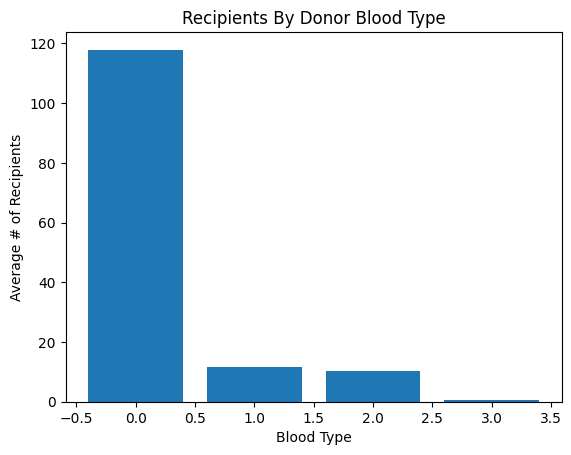

In [20]:
import matplotlib.pyplot as plt


# Extract keys and values
labels = list(avgs.keys())
values = list(avgs.values())

# Create the bar graph
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Blood Type')
plt.ylabel('Average # of Recipients')
plt.title('Recipients By Donor Blood Type')

# Show the plot
plt.show()

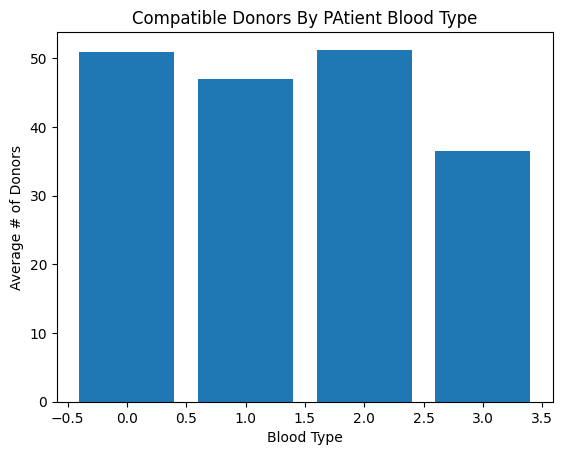

In [21]:
import matplotlib.pyplot as plt


# Extract keys and values
labels = list(avg.keys())
values = list(avg.values())

# Create the bar graph
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Blood Type')
plt.ylabel('Average # of Donors')
plt.title('Compatible Donors By PAtient Blood Type')

# Show the plot
plt.show()

IDEA. Sort by available donors (predecessors of pair i)    Start by selecting cycles where patients with limited options are matched

In [ ]:
def add_info(data):
    p = []
    G = create_graph(data)
    for pair in G.nodes:
        info = {'patient_type':data['pairs'][pair]['patient_blood_type'], 'pot_donors' : len(list(G.predecessors(pair)))}
        data['pairs'][pair]['Av_donors'] = len(list(G.predecessors(pair)))
        p.append(info)
    p[0:3]
    
    d = []
    G = create_graph(data)
    for pair in G.nodes:
        info = {'donor_type':data['pairs'][pair]['donor_blood_type'], 'recipients' : len(list(G.successors(pair)))}
        data['pairs'][pair]['Av_recip'] = len(list(G.successors(pair)))
    
        d.append(info)
    d[0:3]
    return data

Simmulated Annealing